<a href="https://colab.research.google.com/github/pleteneva/Detection-vehicle-registration-plate/blob/main/Detection_vehicle_registration_plate_(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка необходимых библиотек

In [1]:
!pip install -q albumentations -U
!pip install -q pytorch_lightning

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 37.6MB 134kB/s 
     |████████████████████████████████| 952kB 58.2MB/s 
     |████████████████████████████████| 829kB 6.1MB/s 
     |████████████████████████████████| 112kB 49.1MB/s 
     |████████████████████████████████| 829kB 45.1MB/s 
     |████████████████████████████████| 276kB 59.7MB/s 
     |████████████████████████████████| 1.3MB 49.0MB/s 
     |████████████████████████████████| 143kB 55.0MB/s 
     |████████████████████████████████| 296kB 63.5MB/s 


## Импорт библиотек

In [32]:
import pytorch_lightning as pl
import torch
import numpy as np
import random
import numpy
import os
import sys
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2
import torchvision.transforms as transforms 
import seaborn as sns

%matplotlib inline
import random

import cv2
import torch
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
from typing import Optional, List

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA")

def set_figure_size(figsize=(10, 10), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Torch 1.8.0+cu101
Use CUDA


In [22]:
!git clone https://github.com/pleteneva/Detection-vehicle-registration-plate.git tmp
!mv tmp/* ./.
!rm -rf tmp

Cloning into 'tmp'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 56 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (56/56), done.
mv: cannot move 'tmp/conf' to '././conf': Directory not empty


In [23]:
from dataset_open_images import OpenImagesDataset
from visualization import visualize_from_dataset, visualize_prediction_plate
from support_utils import freeze_seed
from train_loop import train_one_epoch

In [5]:
freeze_seed()

## Датасет

In [6]:
root = 'data/'
class_name = ['Vehicle registration plate']

In [7]:
img_transforms_train = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5),
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.GaussianBlur(3, sigma=(0.1, 5.0))]),
    transforms.ToTensor(),
])

img_transforms_test = transforms.Compose([
    transforms.ToTensor(),
])

In [8]:
train_ds = OpenImagesDataset(root=root,
                             part='train', 
                             class_names = class_name,
                             transforms = img_transforms_train)
val_ds = OpenImagesDataset(root=root, 
                           part='validation', 
                           class_names = class_name,
                           transforms = img_transforms_test)
test_ds = OpenImagesDataset(root=root, 
                            part='test', 
                            class_names = class_name,
                            transforms = img_transforms_test)

print("\ntrain dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))
print("test dataset length:", len(test_ds))

installing boto3 and botocore for downloader by openimages ...

train dataset length: 5368
validation dataset length: 724
test dataset length: 2065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


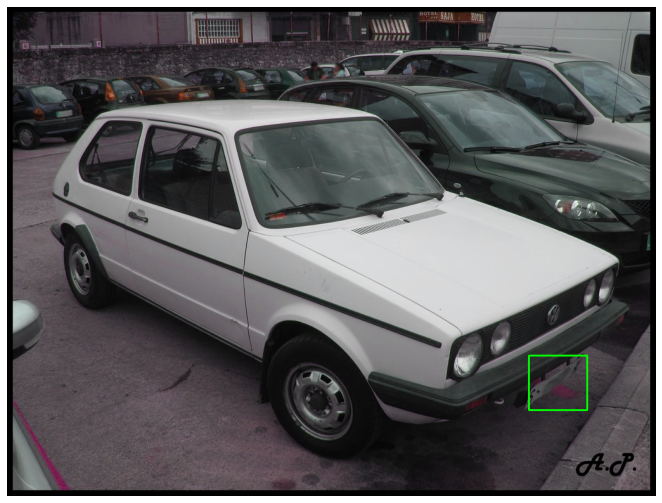

In [9]:
visualize_from_dataset(train_ds[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


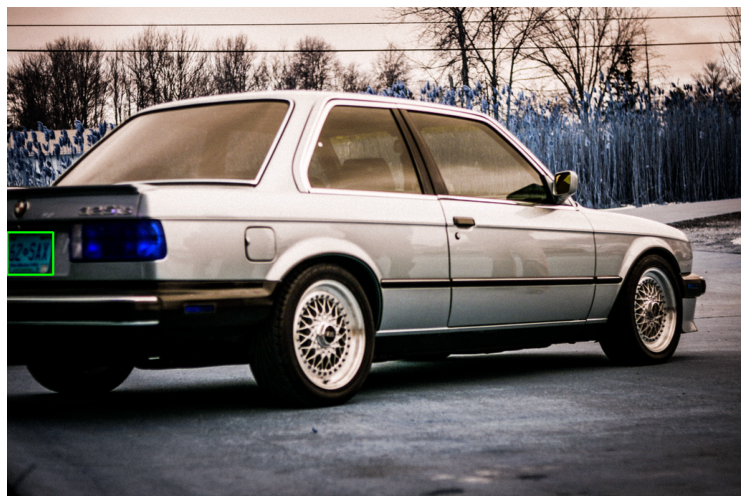

In [10]:
visualize_from_dataset(val_ds[10])

## Make dataloaders

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))


data_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=8, shuffle=True, 
    collate_fn=collate_fn, drop_last=True, num_workers=4)

data_loader_val = torch.utils.data.DataLoader(
    val_ds, batch_size=8, shuffle=False, 
    collate_fn=collate_fn, drop_last=False, num_workers=4)

data_loader_test = torch.utils.data.DataLoader(
    test_ds, batch_size=8, shuffle=False, 
    collate_fn=collate_fn, drop_last=False, num_workers=4)

## Model

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import math
import sys
import time
import torch
from engine import evaluate

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
                                                             progress=True,
                                                             num_classes=91, 
                                                             pretrained_backbone=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [14]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [15]:
assert model.roi_heads.box_predictor.cls_score.in_features == 1024
assert model.roi_heads.box_predictor.cls_score.out_features == 2
assert model.roi_heads.box_predictor.bbox_pred.out_features == 8

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for param in model.parameters():
    param.requires_grad = False
    
for param in model.rpn.parameters():
    param.requires_grad = True
    
for param in model.roi_heads.parameters():
    param.requires_grad = True

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, 
                            lr=0.01,
                            momentum=0.9, 
                            weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=30,
                                               gamma=0.1)

In [17]:
num_epochs=30
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    lr_scheduler.step()
    evaluate(model, data_loader_val, device=device)
    torch.save(model.state_dict(), 'model_state_dict_last.pth')

Epoch: [0]  [  0/671]  eta: 0:21:13  lr: 0.000025  loss: 1.3950 (1.3950)  loss_classifier: 0.8404 (0.8404)  loss_box_reg: 0.0098 (0.0098)  loss_objectness: 0.4938 (0.4938)  loss_rpn_box_reg: 0.0511 (0.0511)  time: 1.8986  data: 1.0092
Epoch: [0]  [ 50/671]  eta: 0:06:11  lr: 0.000770  loss: 0.3299 (0.5893)  loss_classifier: 0.0642 (0.2087)  loss_box_reg: 0.0302 (0.0308)  loss_objectness: 0.1383 (0.3006)  loss_rpn_box_reg: 0.0203 (0.0491)  time: 0.5600  data: 0.0245
Epoch: [0]  [100/671]  eta: 0:05:26  lr: 0.001516  loss: 0.1965 (0.4202)  loss_classifier: 0.0646 (0.1407)  loss_box_reg: 0.0601 (0.0425)  loss_objectness: 0.0473 (0.1938)  loss_rpn_box_reg: 0.0165 (0.0432)  time: 0.5744  data: 0.0236
Epoch: [0]  [150/671]  eta: 0:04:51  lr: 0.002261  loss: 0.1691 (0.3503)  loss_classifier: 0.0519 (0.1129)  loss_box_reg: 0.0653 (0.0501)  loss_objectness: 0.0347 (0.1467)  loss_rpn_box_reg: 0.0135 (0.0406)  time: 0.5441  data: 0.0247
Epoch: [0]  [200/671]  eta: 0:04:21  lr: 0.003007  loss: 0.1

In [25]:
model.load_state_dict(torch.load('model_state_dict_last.pth'))
model.to(device)
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/259]  eta: 0:05:44  model_time: 0.5967 (0.5967)  evaluator_time: 0.0248 (0.0248)  time: 1.3292  data: 0.6622
Test:  [100/259]  eta: 0:01:11  model_time: 0.3596 (0.3861)  evaluator_time: 0.0070 (0.0072)  time: 0.4227  data: 0.0256
Test:  [200/259]  eta: 0:00:26  model_time: 0.3600 (0.3867)  evaluator_time: 0.0064 (0.0070)  time: 0.4399  data: 0.0250
Test:  [258/259]  eta: 0:00:00  model_time: 0.3602 (0.3875)  evaluator_time: 0.0064 (0.0069)  time: 0.4391  data: 0.0224
Test: Total time: 0:01:55 (0.4441 s / it)
Averaged stats: model_time: 0.3602 (0.3875)  evaluator_time: 0.0064 (0.0069)
Accumulating evaluation results...
DONE (t=0.27s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.838
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small 

Class: Vihicle registration plate, Confidence: 0.9915903210639954


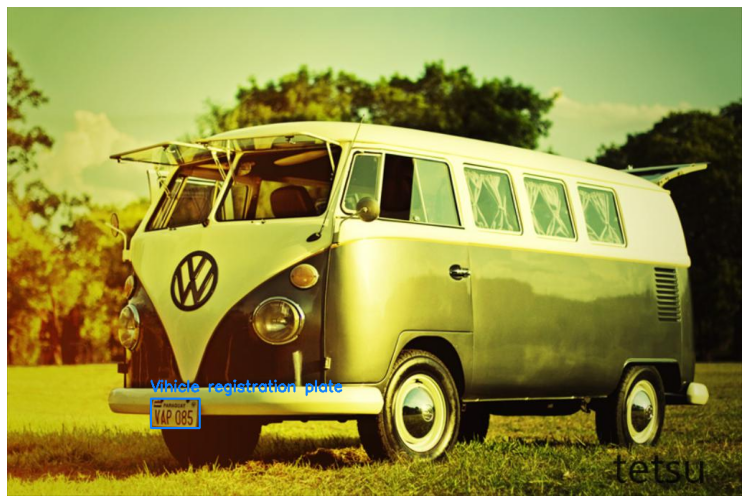

{'boxes': tensor([[200.4282, 546.6478, 268.3014, 587.1830],
         [133.7327, 535.7047, 283.8867, 586.1266],
         [228.4541, 343.3169, 292.9317, 423.7851]], device='cuda:0'),
 'labels': tensor([1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9916, 0.0776, 0.0532], device='cuda:0')}

In [37]:
idx = np.random.choice(range(len(test_ds)))

visualize_prediction_plate(idx, test_ds, model, 
                           id_to_name={1: 'Vihicle registration plate'}, thresh=0.8)